In [ ]:
import os
import math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from optimization import utils
from optimization import SequenceSignal
from optimization.SequenceSignal import Sequence
from optimization import transformer_model
from optimization import train_val_loops
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, auc
from sklearn.metrics import auc
from scipy.stats import pearsonr
import pandas as pd
from torchinfo import summary
import math

In [2]:
# Global variables
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
N_EPOCHS = 30
OUTPUT_SHAPE = 9
SEQ_LENGTH = 2000
WINDOW_SIZE = '1kb'
SIGNAL_SIZE = 300
N_TEST_EXAMPLES = np.load(f'peaks/val_target.npy').shape[0]
N_TRAIN_EXAMPLES = np.load(f'peaks/train_target.npy').shape[0]
PATIENCE = 20

In [3]:
model = transformer_model2.TransformerCNNMixtureModel(n_conv_layers = 4, n_filters = [256, 60, 60, 120], 
                                   kernel_sizes = [7, 3, 5, 3], dilation = [1, 1, 1, 1], 
                                   drop_conv = 0.1, n_fc_layers = 2, 
                                   drop_fc = 0.4, sequence_length = SEQ_LENGTH, 
                                   n_neurons = [256, 256], output_size = OUTPUT_SHAPE, drop_transformer=0.2, input_size=4, 
                                                     n_encoder_layers = 2, n_heads=8, n_transformer_FC_layers=256)

model.to(device=DEVICE)
CRITERION = torch.nn.MSELoss()
summary(model)

Layer (type:depth-idx)                                            Param #
TransformerCNNMixtureModel                                        --
├─ModuleList: 1-1                                                 --
│    └─Sequential: 2-1                                            --
│    │    └─ConvPoolingBlock: 3-1                                 7,936
│    └─Sequential: 2-2                                            --
│    │    └─ConvPoolingBlock: 3-2                                 46,260
│    └─Sequential: 2-3                                            --
│    │    └─ConvPoolingBlock: 3-3                                 18,180
│    └─Sequential: 2-4                                            --
│    │    └─ConvPoolingBlock: 3-4                                 21,960
├─PositionalEncoding: 1-2                                         --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─Tr

In [4]:
dataloaders = utils.load_dataset(f'peaks/dataset_train_augmented_encoding.npy', 
                                 f'peaks/targets_zscore.npy', 
                                 f'peaks/dataset_1kb_300bp_S3_val_encoding.npy', 
                                 f'peaks/val_target.npy', 
                                 BATCH_SIZE, device = DEVICE, 
                                 sqrt_transform = False,
                                 num_mutations = 0)

In [5]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3, weight_decay = 1e-4)
#optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-3, weight_decay = 1e-4)
#optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3, momentum = 0.9)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', threshold = 1e-1)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, epochs = N_EPOCHS, max_lr = 1e-3, 
                                             steps_per_epoch = math.ceil(N_TRAIN_EXAMPLES / dataloaders[0].batch_size), 
                                             pct_start = 0.1, anneal_strategy = 'linear')

In [6]:
if not os.path.exists(f'checkpoint_{WINDOW_SIZE}_{SIGNAL_SIZE}bp.pth'):
    
    output=train_val_loops.train_N_epochs(model, optimizer, criterion = CRITERION, 
                                          train_loader = dataloaders[0], valid_loader = dataloaders[1], 
                                          num_epochs = N_EPOCHS, verbose = True, patience = PATIENCE, 
                                          model_path = f'checkpoint_{WINDOW_SIZE}_{SIGNAL_SIZE}bp.pth', lr_scheduler=lr_scheduler, 
                                          means_path='peaks/zscore_means.npy', stds_path='peaks/zscore_stds.npy')
else:
    training_state = torch.load(f'checkpoint_{WINDOW_SIZE}_{SIGNAL_SIZE}bp.pth', weights_only = False)
    optimizer.load_state_dict(training_state['optimizer'])
    lr_scheduler. load_state_dict(training_state['lr_sched'])
    model.load_state_dict(training_state['network'])
    #output=train_val_loops2.train_N_epochs(model, optimizer, criterion = CRITERION, 
     #                                     train_loader = dataloaders[0], valid_loader = dataloaders[1], 
      #                                   num_epochs = N_EPOCHS, verbose = True, patience = PATIENCE, 
       #                                  model_path = 'checkpoint.pth', lr_scheduler=lr_scheduler, 
        #                                   best_valid_loss = training_state['best_valid_loss'])

Training model:
TransformerCNNMixtureModel(
  (convs): ModuleList(
    (0): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): Conv1d(4, 256, kernel_size=(7,), stride=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout1d(p=0.1, inplace=False)
          (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): Conv1d(256, 60, kernel_size=(3,), stride=(1,))
          (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout1d(p=0.1, inplace=False)
          (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (2): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): C

KeyboardInterrupt: 

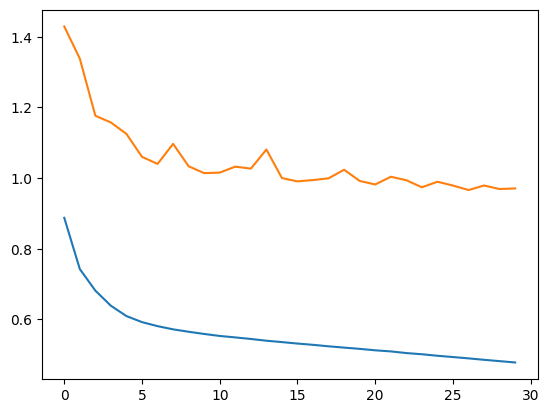

In [8]:
plt.plot(output[0][0])
plt.plot(output[0][1])
plt.show()

In [7]:
model.eval()
y_predict = torch.zeros((N_TEST_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)
y_true = torch.zeros((N_TEST_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(dataloaders[1], 0):
        inputs, labels = data
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(inputs)
        y_true[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = labels

y_true_array = y_true.cpu().numpy()
y_predict_array = (y_predict).cpu().numpy()
print(CRITERION(y_predict, y_true))

tensor(16.4810, device='cuda:0')


In [7]:
# Load mean and std used for z-score normalization
mean = np.load("peaks/zscore_means.npy")  # shape: (OUTPUT_SHAPE,)
std = np.load("peaks/zscore_stds.npy")    # shape: (OUTPUT_SHAPE,)

# Convert to torch tensors for broadcast compatibility
mean_tensor = torch.tensor(mean, device=DEVICE).view(1, -1)
std_tensor = torch.tensor(std, device=DEVICE).view(1, -1)

model.eval()
y_predict = torch.zeros((N_TEST_EXAMPLES, OUTPUT_SHAPE), device=DEVICE)
y_true = torch.zeros((N_TEST_EXAMPLES, OUTPUT_SHAPE), device=DEVICE)

with torch.inference_mode():
    for i, data in enumerate(dataloaders[1], 0):
        inputs, labels = data
        outputs = model(inputs)

        # Reverse z-score normalization
        outputs_denorm = outputs * std_tensor + mean_tensor

        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE

        y_predict[start_idx:end_idx] = outputs_denorm
        y_true[start_idx:end_idx] = labels

# Convert to numpy arrays
y_true_array = y_true.cpu().numpy()
y_predict_array = y_predict.cpu().numpy()

# Optional: compute loss on original scale (log2 scale here)
print(CRITERION(y_predict, y_true))

tensor(0.9662, device='cuda:0')


In [8]:
for j in range(OUTPUT_SHAPE):
    print(pearsonr(y_true_array[:, j], y_predict_array[:, j]))

PearsonRResult(statistic=np.float32(0.72698367), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.7034667), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.7140643), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.6710153), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.68681896), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.7184835), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.6797421), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.71273196), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.73213613), pvalue=np.float64(0.0))


In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data1 = y_predict_array[:10000, :]

# Cluster just once
g = sns.clustermap(data1,
                   cmap='viridis',
                   yticklabels=False,
                   xticklabels=False,
                   figsize=(6, 10))

# Save row and column order
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Save for reuse
np.save("row_order.npy", row_order)
np.save("col_order.npy", col_order)

# You may skip saving this heatmap if you don't need the dendrograms
plt.close()

In [47]:
# Load or use a second dataset (same shape or compatible)
data2 = y_true_array[:10000, :]
# Reuse clustering order
row_order = np.load("row_order.npy")
col_order = np.load("col_order.npy")

# Reorder both datasets
data1_reordered = data1[row_order, :][:, col_order]
data2_reordered = data2[row_order, :][:, col_order]

# Set a consistent figure size
figsize = (6, 10)

# Save both as same-size PDF heatmaps
for idx, (data, name) in enumerate([(data1_reordered, "predicted.pdf"),
                                    (data2_reordered, "true.pdf")]):
    plt.figure(figsize=figsize)
    sns.heatmap(scaler.fit_transform(data),
                cmap='viridis',
                yticklabels=False,
                xticklabels=["WID", "EAD", "AB", "E5", "E11", "E13", "HID", "O", "LB"])
    plt.savefig(name, format='pdf', bbox_inches='tight')
    plt.close()

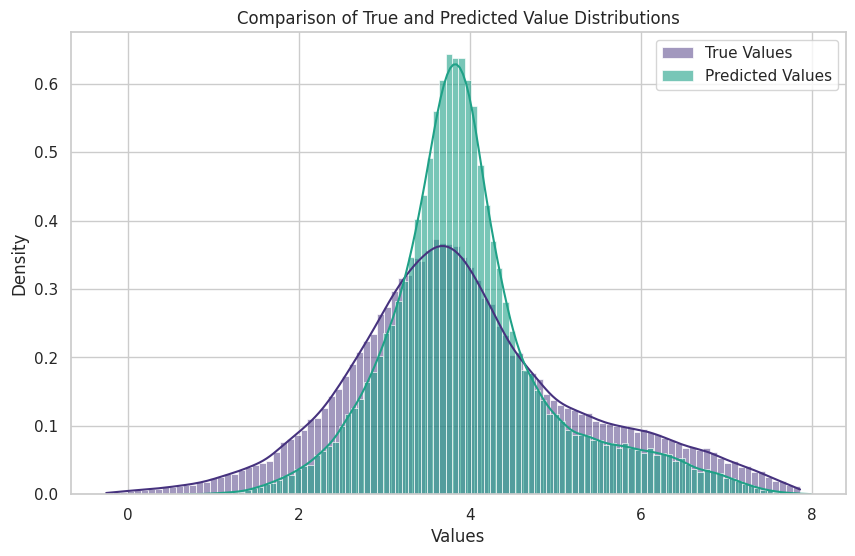

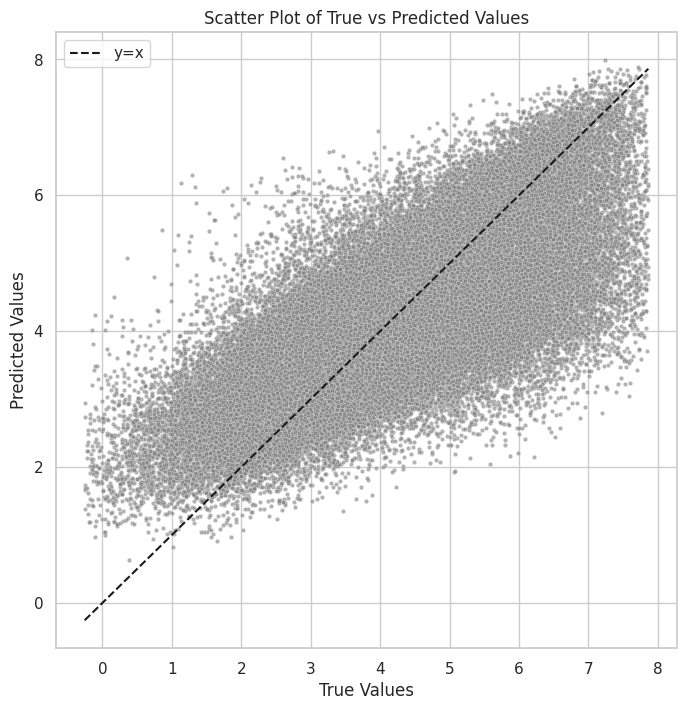

In [10]:
C = 8

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("viridis")

# Histogram comparison plot
plt.figure(figsize=(10, 6))
sns.histplot(y_true_array[:, C], bins=100, color=palette[0], kde=True, label='True Values', stat="density")
sns.histplot(y_predict_array[:, C], bins=100, color=palette[3], kde=True, label='Predicted Values', alpha=0.6, stat="density")
plt.xlabel("Values")
plt.ylabel("Density")
plt.title("Comparison of True and Predicted Value Distributions")
plt.legend()
plt.show()

# Scatter plot with a y=x line
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true_array[:, C], y=y_predict_array[:, C], s=10, color='grey', alpha=0.6)
plt.plot([min(y_true_array[:, C]), max(y_true_array[:, C])], [min(y_true_array[:, C]), max(y_true_array[:, C])], 
         'k--', linewidth=1.5, label="y=x")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of True vs Predicted Values")
plt.legend()
plt.show()

from scipy.stats import gaussian_kde

# Calculate the point density
#x = y_true_array[:, C]
#y = y_predict_array[:, C]
#xy = np.vstack([x, y])
#z = gaussian_kde(xy)(xy)

# Set up the plot
#plt.figure(figsize=(8, 8))
#scatter = plt.scatter(x, y, c=z, s=10, cmap='viridis', alpha=0.7)
#plt.colorbar(scatter, label='Density')
#plt.plot([min(x), max(x)], [min(x), max(x)], 'k--', linewidth=1.5, label="y=x")

# Add labels and title
#plt.xlabel("True Values")
#plt.ylabel("Predicted Values")
#plt.title("Scatter Plot of True vs Predicted Values (Density Colored)")
#plt.legend()
#plt.show()


In [27]:
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

# Calculate the point density
x = y_true_array[:, C]
y = y_predict_array[:, 0]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Create a DataFrame for easier plotting with Seaborn
import pandas as pd
data = pd.DataFrame({'True Values': x, 'Predicted Values': y, 'Density': z})

# Set up the joint plot with marginal distributions
g = sns.jointplot(
    data=data, x='True Values', y='Predicted Values', 
    kind="scatter", palette="magma_r", alpha=0.7, s=10, marginal_kws=dict(bins=200, fill=True, color = '#FF6666')
)

# Customize the plot
g.plot_joint(plt.scatter, c=data['Density'], cmap="magma_r", s=10, alpha=0.7)
g.ax_joint.plot([min(x), max(x)], [min(x), max(x)], 'k--', linewidth=1.5)  # y=x line
#g.figure.colorbar(g.ax_joint.collections[0], label="")  # Add colorbar for density

# Add titles and labels
g.ax_joint.set_xlabel("Log2 (ATAC-seq normalized signal)")
g.ax_joint.set_ylabel("Predicted Log2 (ATAC-seq normalized signal)")
g.ax_joint.set_title("Haltere imaginal disc true values vs Adult Brain predicted values", pad = 70)
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 34939 and the array at index 1 has size 281063

In [10]:
y_predict_array.shape

(34939, 8)

In [8]:
val = Sequence('model_validation/validation_interval_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs = model(data)

        # Reverse z-score normalization
        outputs_denorm = outputs * std_tensor + mean_tensor

        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE

        y_predict[start_idx:end_idx] = outputs_denorm


In [9]:
y_predict_array = (2**y_predict).cpu().numpy()
#y_predict_array = y_predict.cpu().numpy()

In [10]:
np.savetxt("model_validation/val_predictions.txt", y_predict_array, fmt='%f\t')

In [14]:
val = Sequence('model_validation/validation_interval_chr3L_neg_strand_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(data)

#y_predict_array = (2**y_predict).cpu().numpy()
y_predict_array_neg_strand = y_predict.cpu().numpy()

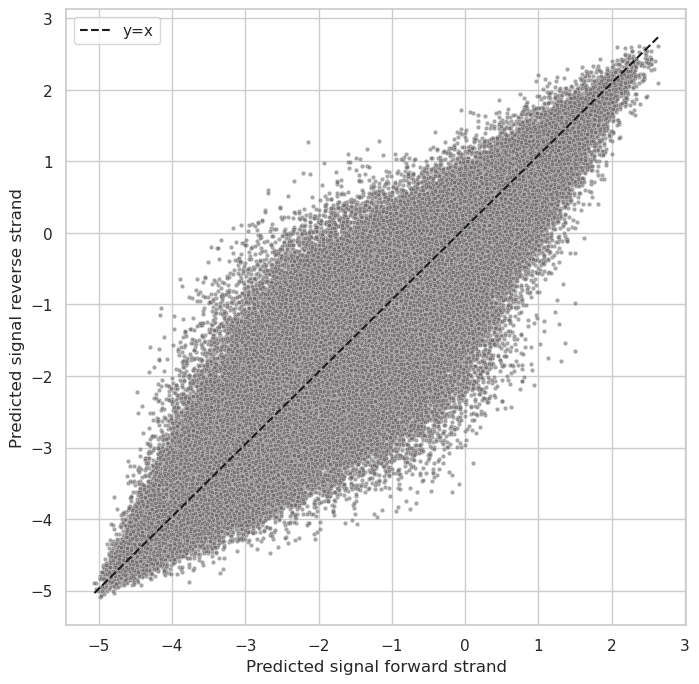

In [23]:
C = 7

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("viridis")

# Scatter plot with a y=x line
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_predict_array_neg_strand[:, C], y=y_predict_array[:, C], s=10, color='#6D696A', alpha=0.6)
plt.plot([min(y_predict_array_neg_strand[:, C]), max(y_predict_array_neg_strand[:, C])], [min(y_true_array[:, C]), max(y_true_array[:, C])], 
         'k--', linewidth=1.5, label="y=x")
plt.xlabel("Predicted signal forward strand")
plt.ylabel("Predicted signal reverse strand")
plt.title("")
plt.legend()
plt.show()


In [14]:
val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_UAS_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data)
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_UAS = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF1_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data)
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_grh_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_grh = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_ovo_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data)
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_ovo = (y_predict).cpu().numpy()


val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_zelda_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_vfl = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF2_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA_2 = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF3_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA_3 = (y_predict).cpu().numpy()

val = Sequence('motif_embedding_test/motif2/random_dna_sequences_with_GAF4_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs_denorm = model(data) 
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = outputs_denorm

y_predict_array_GAGA_4 = (y_predict).cpu().numpy()

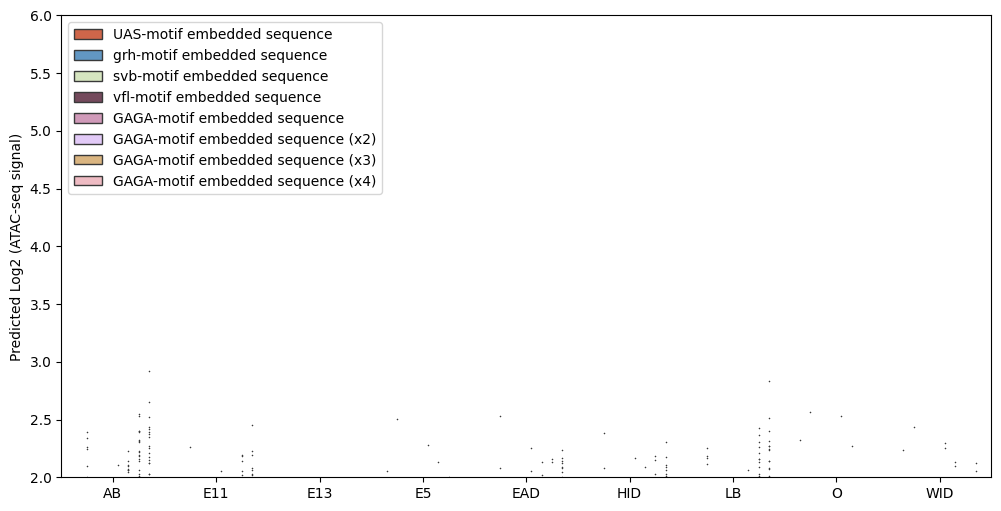

In [16]:
# Convert arrays into a DataFrame
columns = ['AB', 'E11', 'E13', 'E5', 'EAD', 'HID', 'LB', 'O', 'WID']
UAS = pd.DataFrame(y_predict_array_UAS, columns=columns)
GAGA = pd.DataFrame(y_predict_array_GAGA, columns=columns)
GAGA_2 = pd.DataFrame(y_predict_array_GAGA_2, columns=columns)
GAGA_3 = pd.DataFrame(y_predict_array_GAGA_3, columns=columns)
GAGA_4 = pd.DataFrame(y_predict_array_GAGA_4, columns=columns)
grh = pd.DataFrame(y_predict_array_grh, columns=columns)
ovo = pd.DataFrame(y_predict_array_ovo, columns=columns)
vfl = pd.DataFrame(y_predict_array_ovo, columns=columns)
# Add a column to indicate the type (predicted or true) and concatenate the dataframes
UAS['Type'] = 'UAS-motif embedded sequence'
grh['Type'] = 'grh-motif embedded sequence'
GAGA['Type'] = 'GAGA-motif embedded sequence'
GAGA_2['Type'] = 'GAGA-motif embedded sequence (x2)'
GAGA_3['Type'] = 'GAGA-motif embedded sequence (x3)'
GAGA_4['Type'] = 'GAGA-motif embedded sequence (x4)'
ovo['Type'] = 'svb-motif embedded sequence'
vfl['Type'] = 'vfl-motif embedded sequence'
# Combine both dataframes
df_combined = pd.concat([UAS, grh, ovo, vfl, GAGA, GAGA_2, GAGA_3, GAGA_4])
custom_palette = ["#E55934", "#5299D3", "#D7EBBA", "#7B435B", "#D991BA", '#E2C2FF', '#E9B872', '#F7B2BD'] 
# Melt the dataframe to make it compatible with seaborn
df_melted = df_combined.melt(id_vars='Type', var_name='Task', value_name='Value')

# Plot boxplots
plt.figure(figsize=(12, 6))
flierprops = dict(marker='x', color='black', markersize=0.5)
sns.boxplot(data=df_melted, x='Task', y='Value', hue='Type', palette = custom_palette, flierprops=flierprops)
plt.title("")
plt.xlabel("")
plt.ylim(2, 6)
plt.ylabel("Predicted Log2 (ATAC-seq signal)")
plt.legend(loc='upper left')
plt.show()

In [17]:
val = Sequence('EMBL_lines/line_sequences_encoding.npy', device = DEVICE)
BATCH_SIZE = 1
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(data)

y_predict_array = (2**y_predict).cpu().numpy()


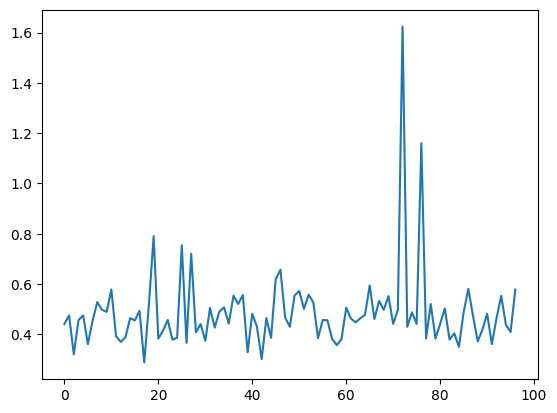

In [18]:
plt.plot(y_predict_array[:, 6])

In [19]:
columns = ['AB', 'E11', 'E13', 'E5', 'EAD', 'HID', 'LB', 'WID']

In [20]:
(y_predict_array[:, 6])

array([0.4408549 , 0.4752772 , 0.32102004, 0.4567555 , 0.47515553,
       0.3613234 , 0.45422727, 0.52829576, 0.4979911 , 0.4897024 ,
       0.57884043, 0.3928846 , 0.3701063 , 0.38891202, 0.4646307 ,
       0.45584834, 0.49400398, 0.28846976, 0.5196858 , 0.7901429 ,
       0.38321862, 0.41511747, 0.45730802, 0.37892893, 0.3869664 ,
       0.75417376, 0.3664883 , 0.7200289 , 0.4077813 , 0.44134036,
       0.3746386 , 0.5055426 , 0.42739812, 0.49116194, 0.507428  ,
       0.4430933 , 0.5541025 , 0.5213424 , 0.5563185 , 0.32907745,
       0.48238975, 0.4303949 , 0.3016499 , 0.46513605, 0.38632792,
       0.6205232 , 0.6569639 , 0.4671119 , 0.43032926, 0.55456656,
       0.57253873, 0.501466  , 0.5577052 , 0.52747726, 0.38537627,
       0.4570541 , 0.45638165, 0.38220635, 0.35711104, 0.38169765,
       0.5060923 , 0.4630673 , 0.4478814 , 0.46398625, 0.4780054 ,
       0.59429085, 0.46125534, 0.53294384, 0.4977578 , 0.55220425,
       0.44148535, 0.49780843, 1.623945  , 0.4302075 , 0.48764

In [50]:
y_predict_array[79, :]

array([0.19523716, 1.0442677 , 0.9929964 , 0.93860257, 0.28187022,
       0.3698214 , 0.24737567, 0.34753093], dtype=float32)

In [48]:
y_predict_array.shape

(97, 8)